In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import zscore, t

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import IsolationForest

from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.metrics import r2_score, mean_absolute_error

from sklearn.neighbors import LocalOutlierFactor


from sklearn.feature_selection import RFE,RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectFromModel


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OrdinalEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
uploaded = 'http://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv'
columns = ['X','Y','month','day','FFMC','DMC','DC','ISI','temp','RH','wind','rain']

df = pd.read_csv(uploaded)
df[['day','month']] = OrdinalEncoder().fit_transform(df[['day','month']])

#scale independent variables
df[columns]=StandardScaler().fit_transform(df[columns])

z = np.abs(zscore(df))
df = df[(z < 3).all(axis=1)]

print(df.shape)
df.head()

(486, 13)


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,1.008313,0.569860,0.284222,-1.423121,-0.805959,-1.323326,-1.830477,-0.860946,-1.842640,0.411724,1.498614,-0.073268,0.0
1,1.008313,-0.244001,0.970871,1.176715,-0.008102,-1.179541,0.488891,-0.509688,-0.153278,-0.692456,-1.741756,-0.073268,0.0
2,1.008313,-0.244001,0.970871,-0.383187,-0.008102,-1.049822,0.560715,-0.509688,-0.739383,-0.692456,-1.518282,-0.073268,0.0
5,1.440925,1.383722,-1.089076,0.136781,0.300161,-0.399665,-0.241863,1.246598,0.570734,-0.937830,0.772325,-0.073268,0.0
6,1.440925,1.383722,-1.089076,-0.903154,0.300161,-0.343401,-0.211197,-0.114524,0.898263,-1.060516,-0.512650,-0.073268,0.0


In [ ]:
X_orig = df[columns]
y = df['area']
pd.DataFrame(data=[df.skew(),df.kurtosis()],index=['skewness','kurtosis'])

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
skewness,0.063923,-0.202949,0.052650,0.159875,-1.685313,0.569870,-1.190412,0.683740,-0.328373,0.706399,0.486262,13.349848,5.326617
kurtosis,-1.172167,-0.449995,-1.747641,-1.113485,4.254761,0.282799,0.011288,0.461803,0.247071,-0.005989,-0.164352,184.836192,35.472354


In [ ]:
outliers = LocalOutlierFactor(20).fit_predict(X_orig)
target_out = LocalOutlierFactor(20).fit_predict(y.values.reshape(-1,1))
outliers = outliers == 1
target_out = target_out == 1
for i,t in enumerate(target_out):
  outliers[i]=outliers[i] and t

X_orig,y=X_orig[outliers],y[outliers]
X_orig.shape

(468, 12)

In [ ]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_orig.values, i) for i in range(X_orig.shape[1])]
vif["features"] = X_orig.columns
vif

,VIF Factor,features
0,1.373100,X
1,1.379897,Y
2,1.560588,month
3,1.062431,day
4,3.162789,FFMC
5,2.752483,DMC
6,2.760612,DC
7,2.520955,ISI
8,2.898281,temp
9,1.913867,RH


In [ ]:
X = X_orig[:]

In [ ]:
k=X.shape[1]

acc_metric = 'neg_mean_squared_error'
# acc_metric = 'neg_mean_absolute_error'

cv = KFold(n_splits=10, shuffle= True,random_state=100)

model_selected=None
minRMSE=np.inf
train_sizes=np.array([0.1,0.2,0.3,0.4,0.5,1.0])

X.shape

(468, 12)

In [ ]:
def get_soc(final_clf, features):
    soc = 0
    n = 7     # for tanh
    if( final_clf.get_params()['activation'] == 'relu' ):
      n = 1
    elif ( final_clf.get_params()['activation'] == 'logistic' ):
      n = 3

    for i in final_clf.get_params()['hidden_layer_sizes']:
      soc += ( 2 * features + n * i )
      features = i
    soc += 2 * features * final_clf.n_outputs_
    return soc

In [ ]:
arr_mse = []
arr_mae = []
arr_soc = []
arr_hls = []

Best Hyperparameters::
{'activation': 'logistic', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.0001}


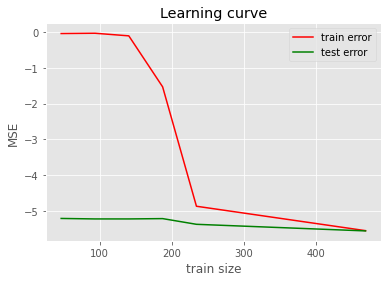

mse :  112.41847198859435
mae :  5.646260089111593
soc :  524


In [ ]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params_1 = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(100,), (100, 100), (100, 100, 100), (100, 100, 100, 100), (100, 100, 100, 100, 100)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params_1, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 12)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)



Best Hyperparameters::
{'activation': 'logistic', 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.0001}


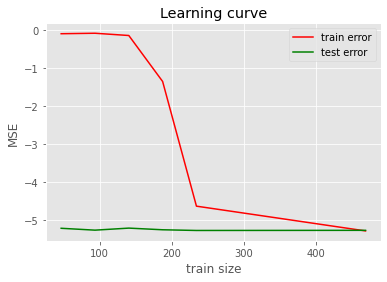

mse :  119.77702779095712
mae :  5.236419890510164
soc :  274


In [ ]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params_2 = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(100,),(150,),(50,),(200,)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params_2, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 12)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)




Best Hyperparameters::
{'activation': 'logistic', 'hidden_layer_sizes': (25,), 'learning_rate_init': 0.0001668100537200059}


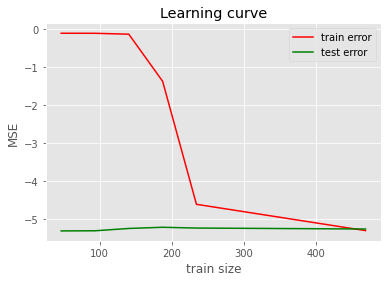

mse :  121.39472940844473
mae :  5.2535352544992575
soc :  149


In [ ]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params_3 = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(25,),(50,),(75)],
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params_3, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 12)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)


Best Hyperparameters::
{'activation': 'logistic', 'hidden_layer_sizes': (25,), 'learning_rate_init': 0.0001}


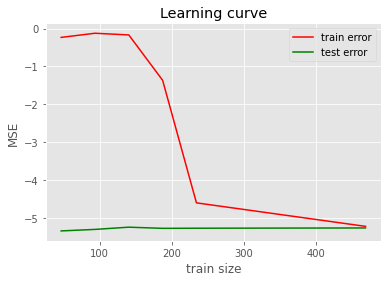

mse :  124.87238199017627
mae :  5.15362398163963
soc :  149


In [ ]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params_4 = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(25,), (35,), (15,)],
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params_4, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 12)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'logistic', 'hidden_layer_sizes': (30,), 'learning_rate_init': 0.0001}


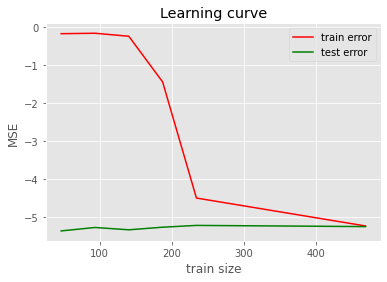

mse :  125.12120423785404
mae :  5.198886149248537
soc :  174


In [ ]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params_5 = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(20,), (30,)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params_5, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 12)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)




Best Hyperparameters::
{'activation': 'logistic', 'hidden_layer_sizes': (27,), 'learning_rate_init': 0.0001668100537200059}


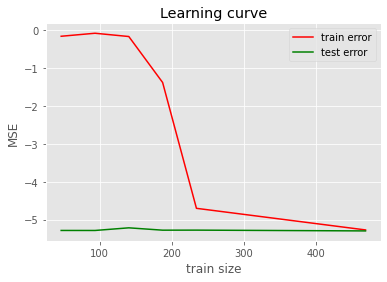

mse :  118.64273707168033
mae :  5.150434560004236
soc :  159


In [ ]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params_6 = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(26,),(27,),(28,),(29,)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params_6, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 12)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)


Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.0001}


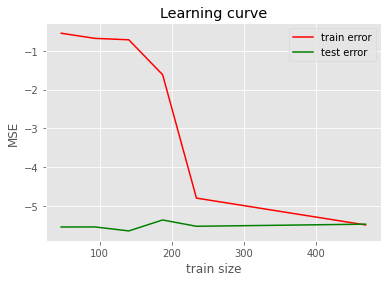

mse :  130.30726227485982
mae :  5.54732540763722
soc :  54


In [ ]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(10,), (5,5), (5,)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 12)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)






Best Hyperparameters::
{'activation': 'logistic', 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.00046415888336127773}


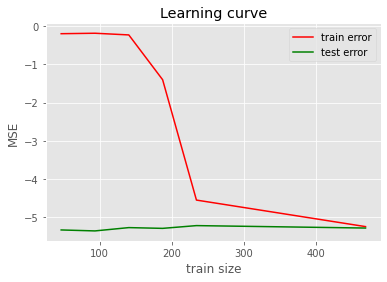

mse :  119.81725052947277
mae :  5.382947889360993
soc :  49


In [ ]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(3,3), (5,)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 12)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)


Best Hyperparameters::
{'activation': 'logistic', 'hidden_layer_sizes': (4,), 'learning_rate_init': 0.0001668100537200059}


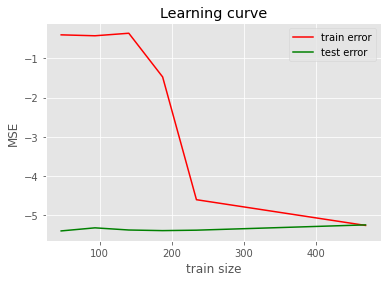

mse :  128.68400946279615
mae :  5.405279314667345
soc :  44


In [ ]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(2,),(4,)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 12)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'tanh', 'hidden_layer_sizes': (1,), 'learning_rate_init': 0.000774263682681127}


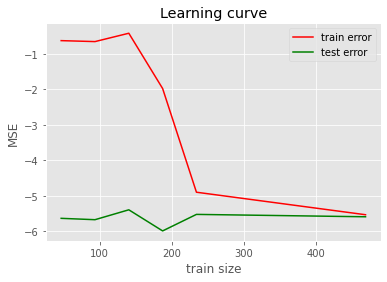

mse :  131.44350328090542
mae :  5.649007231887396
soc :  33


In [ ]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(1,)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 12)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)


Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (1,), 'learning_rate_init': 0.002154434690031882}


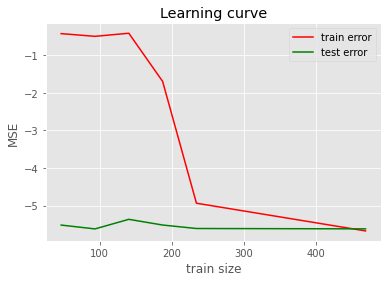

mse :  129.10041250314777
mae :  5.779896030997618
soc :  27


In [ ]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['relu'], 
 'hidden_layer_sizes': [(1,)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 12)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)


In [ ]:
X = X_orig.drop(['FFMC', 'DMC', 'DC', 'temp'],axis=1)

Best Hyperparameters::
{'activation': 'tanh', 'hidden_layer_sizes': (1,), 'learning_rate_init': 0.001291549665014884}


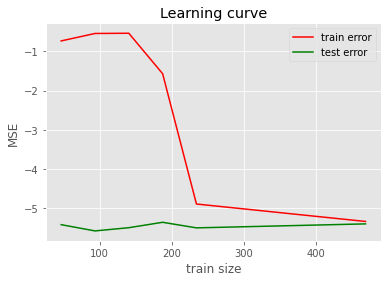

mse :  129.15060103197288
mae :  5.575807878266114
soc :  25


In [ ]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['tanh'], 
 'hidden_layer_sizes': [(1,)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 8)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)


In [ ]:
del arr_mse[-1]
del arr_mae[-1]
del arr_soc[-1]
del arr_hls[-1]

In [ ]:
X = X.drop(['ISI'],axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,1.359473,X
1,1.358932,Y
2,1.059045,month
3,1.050834,day
4,1.048869,RH
5,1.023913,wind
6,1.048202,rain


Best Hyperparameters::
{'activation': 'tanh', 'hidden_layer_sizes': (1,), 'learning_rate_init': 0.00046415888336127773}


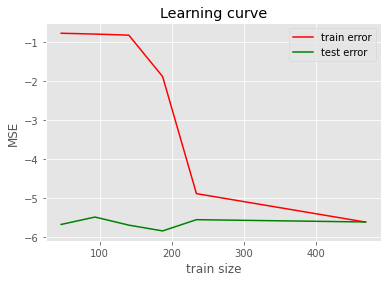

mse :  129.94636840566972
mae :  5.746831712466329
soc :  23


In [ ]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['tanh'], 
 'hidden_layer_sizes': [(1,)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 7)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)


In [ ]:
arr_mae, arr_soc

([5.646260089111593,
  5.236419890510164,
  5.2535352544992575,
  5.15362398163963,
  5.198886149248537,
  5.150434560004236,
  5.54732540763722,
  5.382947889360993,
  5.405279314667345,
  5.649007231887396,
  5.779896030997618,
  5.575807878266114,
  5.746831712466329],
 [524, 274, 149, 149, 174, 159, 54, 49, 44, 33, 27, 25, 23])

In [ ]:
arr_mae_min = [5.150434560004236]
arr_soc_min = [159]
arr_mae_min_soc = [5.575807878266114]
arr_soc_min_soc = [25]

In [ ]:
arr_mae_not_allowed = [ x for x in arr_mae if x >= arr_mae_min[0]*1.1 ]
arr_mae_not_allowed

[5.779896030997618, 5.746831712466329]

In [ ]:
arr_mae_not_allowed_soc = [27, 23]

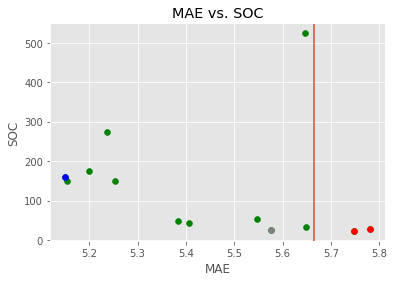

In [ ]:
plt.title("MAE vs. SOC")

plt.scatter(arr_mae, arr_soc, c='green')
plt.scatter(arr_mae_not_allowed, arr_mae_not_allowed_soc, c='red')
plt.scatter(arr_mae_min, arr_soc_min, c='blue')
plt.scatter(arr_mae_min_soc, [25], c='grey')
plt.axvline(x=arr_mae_min[0]*1.1)
plt.xlabel('MAE')
plt.ylabel('SOC')
plt.show()

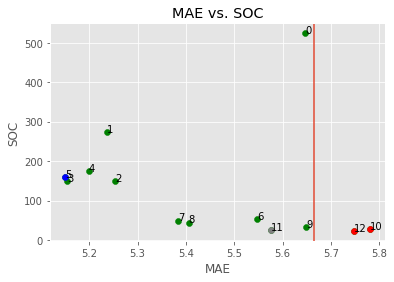

In [ ]:
plt.title("MAE vs. SOC")

plt.scatter(arr_mae, arr_soc, c='green')
plt.scatter(arr_mae_not_allowed, arr_mae_not_allowed_soc, c='red')
plt.scatter(arr_mae_min, arr_soc_min, c='blue')
plt.scatter(arr_mae_min_soc, [25], c='grey')
plt.axvline(x=arr_mae_min[0]*1.1)

for i, txt in enumerate(arr_mae):
    plt.annotate(i, (arr_mae[i], arr_soc[i]))

plt.xlabel('MAE')
plt.ylabel('SOC')
plt.show()

In [ ]:
activation = [ 'logistic','logistic','logistic','logistic','logistic','logistic', 'relu', 'logistic', 'logistic', 'tanh', 'relu', 'tanh', 'tanh' ]

In [ ]:
data = { 'MAE': arr_mae, 'SOC': arr_soc, 'Hidden Layer Size ': arr_hls, 'activation': activation }
df = pd.DataFrame(data)
df

,MAE,SOC,Hidden Layer Size,activation
0,5.646260,524,"(100,)",logistic
1,5.236420,274,"(50,)",logistic
2,5.253535,149,"(25,)",logistic
3,5.153624,149,"(25,)",logistic
4,5.198886,174,"(30,)",logistic
5,5.150435,159,"(27,)",logistic
6,5.547325,54,"(10,)",relu
7,5.382948,49,"(5,)",logistic
8,5.405279,44,"(4,)",logistic
9,5.649007,33,"(1,)",tanh
